In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import scipy.linalg

plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(12,10))
%config InlineBackend.figure_format = 'retina'

Here we analyze the 4-vertex graph with a single cycle, $K_4$.

<img src="k4.png" width="400" height="200">

In [2]:
def round_sig(x, sig_figs=4):
    """
    Rounds a number to a given number of significant figures.
    
    Parameters
    ----------
    x : float
        number to round
        
    sig_figs : integer (default=4)
        number of sig figs to round to
        
    Returns
    ----------
    x rounded to the desired number of significant figures
    """
    if x == 0:
        return 0.0
    return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)

def eq_params_k4():
    """
    Samples equilibrium parameter sets for a 4-state single-cycle graph
    (k12, k23, k34, k41) and (k21, k32, k43, k14), ensuring zero cycle affinity.

    Returns
    -------
    labels_f : list of 4 floats
        Forward rates: [k12, k23, k34, k41]
    labels_r : list of 4 floats
        Reverse rates: [k21, k32, k43, k14]
    """

    # Sample 7 of the 8 parameters freely
    k12 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k23 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k34 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k41 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)

    k21 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k32 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)
    k43 = round_sig(10 ** np.random.uniform(-3, 3), sig_figs=4)

    # Solve for k14 to make the cycle affinity zero
    # A(C) = log[(k12 k23 k34 k41)/(k21 k32 k43 k14)] = 0 → solve for k14
    k14 = (k12 * k23 * k34 * k41) / (k21 * k32 * k43)

    labels_f = [k12, k23, k34, k41]
    labels_r = [k21, k32, k43, k14]

    return labels_f, labels_r

In [3]:
labels_f, labels_r = eq_params_k4()
print(labels_f)
print(labels_r)

aff = np.log(np.prod(labels_f)/np.prod(labels_r))
print(aff)

[12.99, 0.01602, 0.7358, 0.009183]
[614.4, 0.001851, 0.4238, 0.002917409900784878]
0.0


In [3]:
def mtt_k4(labels_f, labels_r):
    # labels_f = k12, k23, k34, k41
    k12, k23, k34, k41 = labels_f[0], labels_f[1], labels_f[2], labels_f[3]
    # labels_r = k21, k32, k43, k14
    k21, k32, k43, k14 = labels_r[0], labels_r[1], labels_r[2], labels_r[3]
    
    rho_1 = (k43*k32*k21) + (k23*k34*k41) + (k32*k21*k41) + (k34*k41*k21) #✅✅
    rho_2 = (k12*k32*k43) + (k14*k43*k32) + (k41*k12*k32) + (k34*k41*k12) #✅✅
    rho_3 = (k12+k23+k43) + (k14*k43*k23) + (k41*k12*k23) + (k21*k14*k43) #✅✅
    rho_4 = (k12*k23*k34) + (k14*k23*k34) + (k32*k21*k14) + (k21*k14*k34) #✅✅

    rho_tot = rho_1 + rho_2 + rho_3 + rho_4
    
    pi = np.array([rho_1/rho_tot, rho_2/rho_tot, rho_3/rho_tot, rho_4/rho_tot],dtype=np.float128)
    
    return pi

In [4]:
def spec_k4(lap):
    eigvals, eigvecs = scipy.linalg.eig(lap)
    v = eigvecs[:, np.argmin(np.abs(eigvals))].real #np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)])
    pi = v / v.sum()
    return pi

In [5]:
def lap_k4(labels_f, labels_r):
    # labels_f = k12, k23, k34, k41
    k12, k23, k34, k41 = labels_f[0], labels_f[1], labels_f[2], labels_f[3]
    # labels_r = k21, k32, k43, k14
    k21, k32, k43, k14 = labels_r[0], labels_r[1], labels_r[2], labels_r[3]
    
    lap = np.array([[-k14-k12, k21, 0, k41], [k12, -k21-k23, k32, 0], [0, k23, -k32-k34, k43], [k14, 0, k34, -k41-k43]],dtype=float)
    
    return lap

In [7]:
lap = lap_k4(labels_f, labels_r)
pi = mtt_k4(labels_f, labels_r)
pi2 = spec_k4(lap)

print("Laplacian:\n", lap)
print("---")
print("Stationary distribution:\n", pi)
print(np.sum(pi))
print("---")
print("Zero right eigenvector:\n",pi2)
print(np.sum(pi2))
print("---")
print("∆(u*(G)):\n", np.diag(pi))
print("---")
print(np.diag(pi).shape)

Laplacian:
 [[-1.29929174e+01  6.14400000e+02  0.00000000e+00  9.18300000e-03]
 [ 1.29900000e+01 -6.14416020e+02  1.85100000e-03  0.00000000e+00]
 [ 0.00000000e+00  1.60200000e-02 -7.37651000e-01  4.23800000e-01]
 [ 2.91740990e-03  0.00000000e+00  7.35800000e-01 -4.32983000e-01]]
---
Stationary distribution:
 [0.22754467 0.00481088 0.69535423 0.07229022]
0.9999999999999999341
---
Zero right eigenvector:
 [0.6571063  0.01389292 0.12024019 0.20876058]
1.0
---
∆(u*(G)):
 [[0.22754467 0.         0.         0.        ]
 [0.         0.00481088 0.         0.        ]
 [0.         0.         0.69535423 0.        ]
 [0.         0.         0.         0.07229022]]
---
(4, 4)


In [8]:
signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 1000, num=500)

In [9]:
def asymmetric_autocorrelation(signal,L,tau,alpha=1,beta=3):
    """
    Numerically calculates the asymmetric autocorrelation functions A^{1,3}(\tau) and A^{3,1}(\tau) for a particular Laplacian matrix. This function works for a linear framework graph of any size.
    
    Parameters
    ----------
    signal : 1D array
        vector of possible values of signal S = (S(1), ..., S(N))
        
    L : NxN array
        column-based Laplacian matrix of linear framework graph with N vertices
    
    tau : 1D array
        range of intervals between values of signal along integration interval
    
    alpha, beta : scalar
        asymmetric exponents applied to signal (default: alpha=1, beta=3)
    
    Returns
    -------
    a_13 : 1D array
        forward autocorrelation function values
    
    a_31 : 1D array
        reverse autocorrelation function values
    
    """
    # initialize forward and reverse autocorrelation function arrays
    a_13 = np.zeros(len(tau),dtype=np.float128)
    a_31 = np.zeros(len(tau),dtype=np.float128)
    
    # define the signal vectors
    s_t = np.array([signal],dtype=np.float128) # row vector
    s = s_t.T # column vector
    
    # create the diagonal steady state matrix
    # calculate the stationary distribution of the Markov process
    pi = np.array(spec_k4(L))
    delta_u_star = np.diag(pi)
    
    # vectorize the Laplacian matrix multiplied by each value in the vector tau
    list_result = list(map(lambda i: scipy.linalg.expm(L*i), tau))
    
    # populate arrays with analytical solution to autocorrelation function
    for i in range(len(tau)):
        a_13[i] = ((s_t**beta) @ list_result[i]) @ (delta_u_star @ (s ** alpha))
        a_31[i] = ((s_t**alpha) @ list_result[i]) @ (delta_u_star @ (s ** beta))
        
    return a_13, a_31

In [10]:
def asymmetric_autocorrelation_2(signal, L, tau, alpha=1, beta=3):
    """
    Computes asymmetric autocorrelations A^{1,3}(tau) and A^{3,1}(tau)
    for a linear framework graph with stationary distribution pi.
    
    Parameters
    ----------
    signal : 1D array-like
        Signal values on each node.
    L : 2D array
        Column-based Laplacian.
    tau : 1D array
        Timepoints for evaluation.
    pi : 1D array
        Stationary distribution (sum to 1).
    alpha, beta : int or float
        Powers for asymmetric observable weights.
    
    Returns
    -------
    a13, a31 : 1D arrays
        Forward and reverse autocorrelation values.
    """
    signal = np.array(signal, dtype=np.float128)
    #pi = np.array(pi, dtype=np.float128)
    S_alpha = signal ** alpha
    S_beta = signal.T ** beta
    
    # calculate the stationary distribution of the Markov process
    pi = np.array(spec_k4(L))

    # Diagonal matrix of steady state
    Delta = np.diag(pi)
    
    # Result arrays
    a13 = np.zeros(len(tau),dtype=np.float128)
    a31 = np.zeros(len(tau),dtype=np.float128)

    for i, t in enumerate(tau):
        expLt = scipy.linalg.expm(L * t,)
        a13[i] = S_beta @ expLt @ Delta @ S_alpha
        a31[i] = S_alpha @ expLt @ Delta @ S_beta

    return a13, a31

In [6]:
def autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3):
    """
    Calculates the analytical solution for forward and reverse higher-order autocorrelation functions for a particular Laplacian matrix
    
    Parameters
    ----------
    observable : 1D array
        possible values of observable (which is a state function on the Markov process)
    L : NxN array
        column-based Laplacian matrix of linear framework graph with N vertices
    tau_n : 1D array
        range of intervals between values of observable taken by system
    alpha : scalar
        exponent applied to observable
    beta : scalar
        exponent applied to transpose of observable
    
    Returns
    -------
    t : 1D array
        forward autocorrelation function values
    t_rev : 1D array
        reverse autocorrelation function values
    
    """
    f = np.array([observable],dtype=np.float128)
    fstar = f.T
    
    # calculate the stationary distribution of the Markov process
    eigvals, eigvecs = scipy.linalg.eig(L)
    pi = np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)]).T
    
    # initialize forward and reverse autocorrelation function arrays
    t = np.zeros(len(tau_n),dtype=np.float128)
    t_rev = np.zeros(len(tau_n),dtype=np.float128)
    
    list_result = list(map(lambda i: scipy.linalg.expm(L*i), tau_n))
    
    # populate arrays with analytical solution to autocorrelation function
    for i in range(len(tau_n)):
        t[i] = f**alpha @ list_result[i] @(fstar ** beta * pi)
        t_rev[i] = f**beta @ list_result[i] @(fstar ** alpha * pi)
        
    return t, t_rev

In [12]:
a13, a31 = asymmetric_autocorrelation(signal,lap,tau,alpha=1,beta=3)

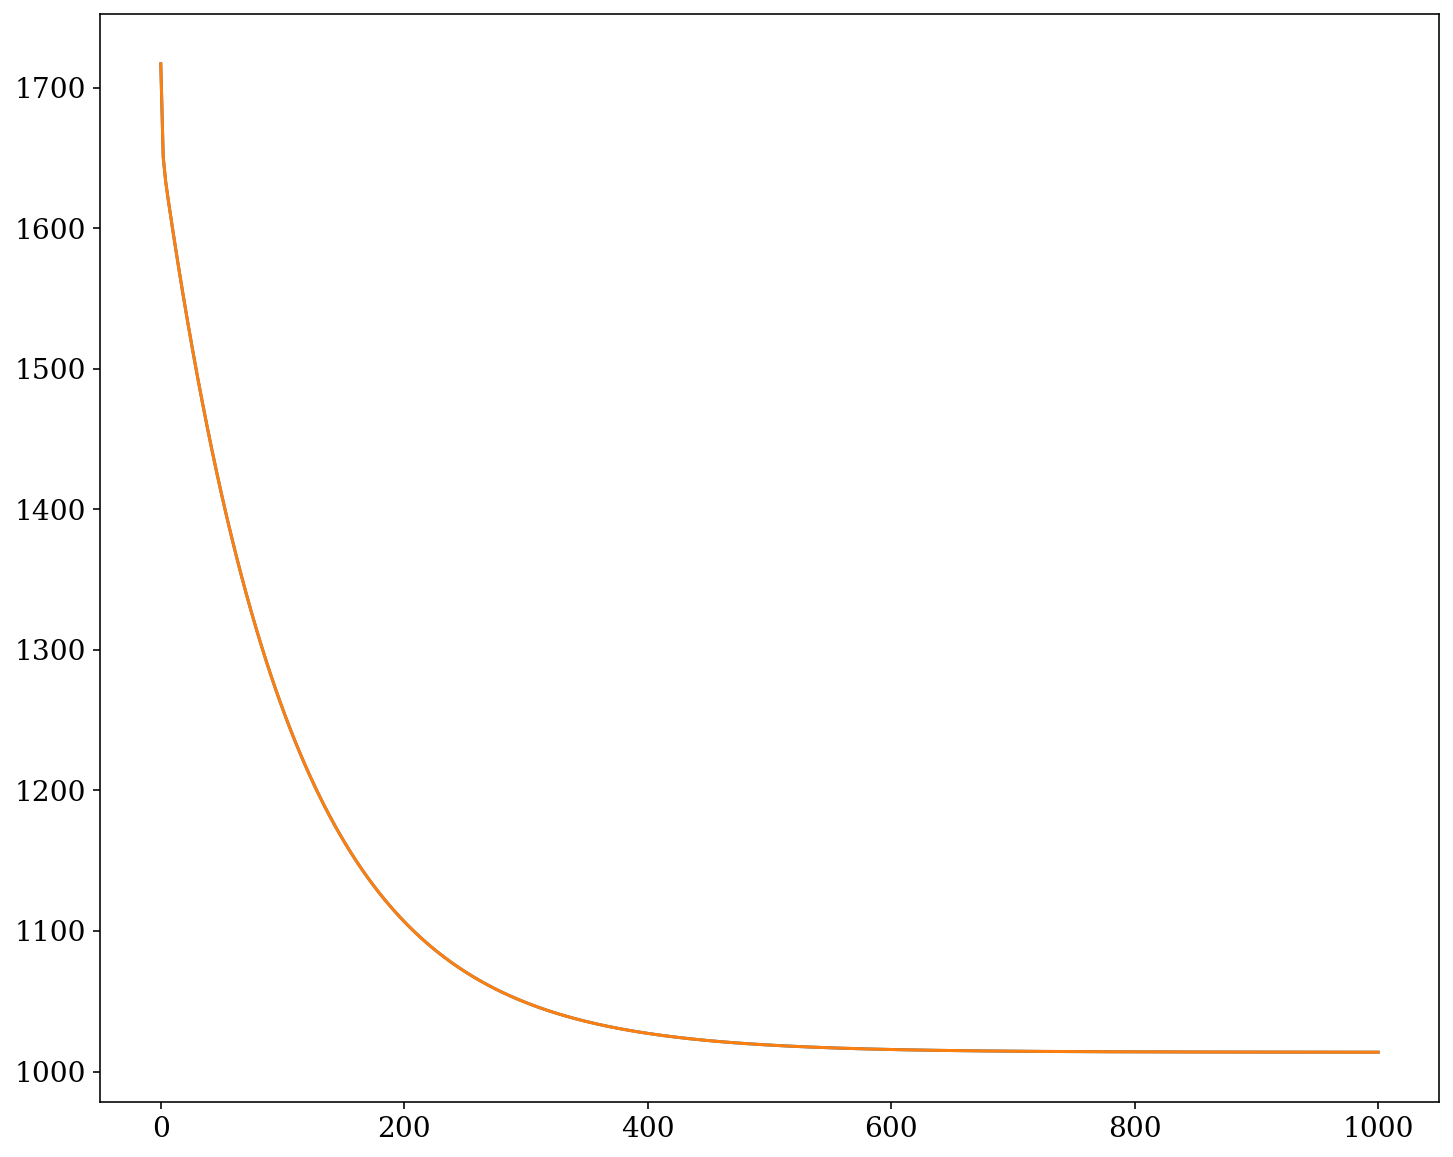

In [13]:
plt.plot(tau,a13)
plt.plot(tau,a31)

In [14]:
area = np.abs(np.trapz(a13)-np.trapz(a31))
print(area)

9.375685294799041003e-08


In [15]:
a13, a31 = asymmetric_autocorrelation_2(signal,lap,tau,alpha=1,beta=3)

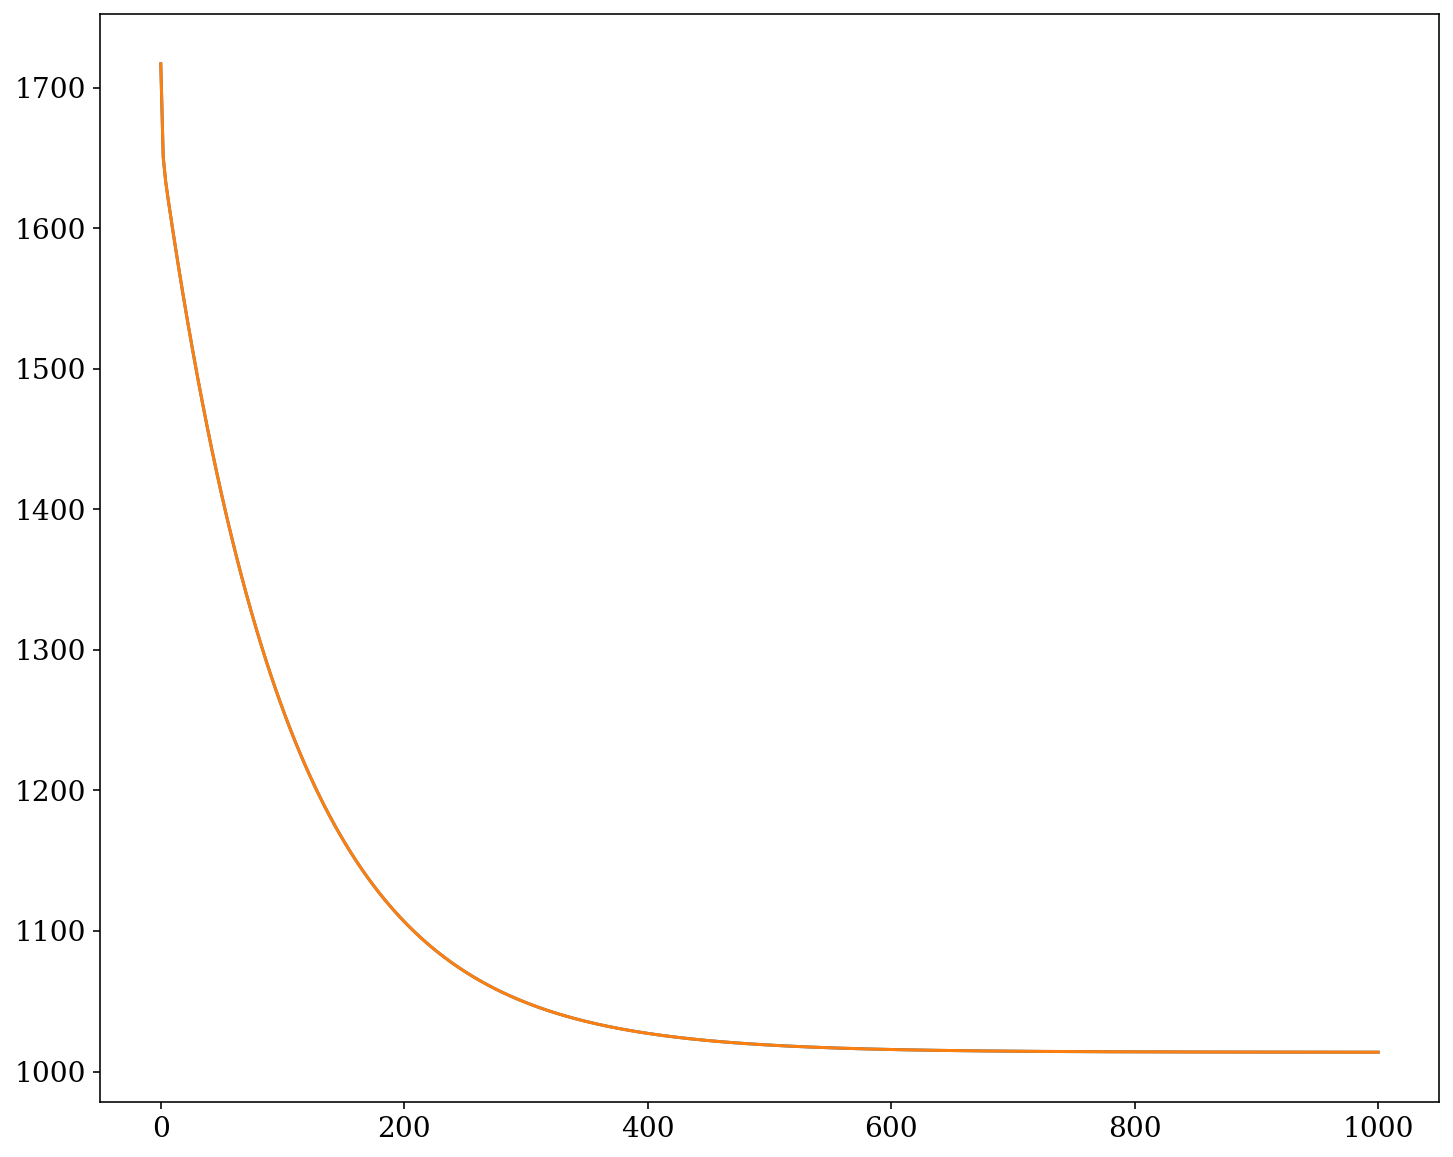

In [16]:
plt.plot(tau,a13)
plt.plot(tau,a31)

In [17]:
area = np.abs(np.trapz(a13)-np.trapz(a31))
print(area)

9.375833087688079104e-08


In [18]:
a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)

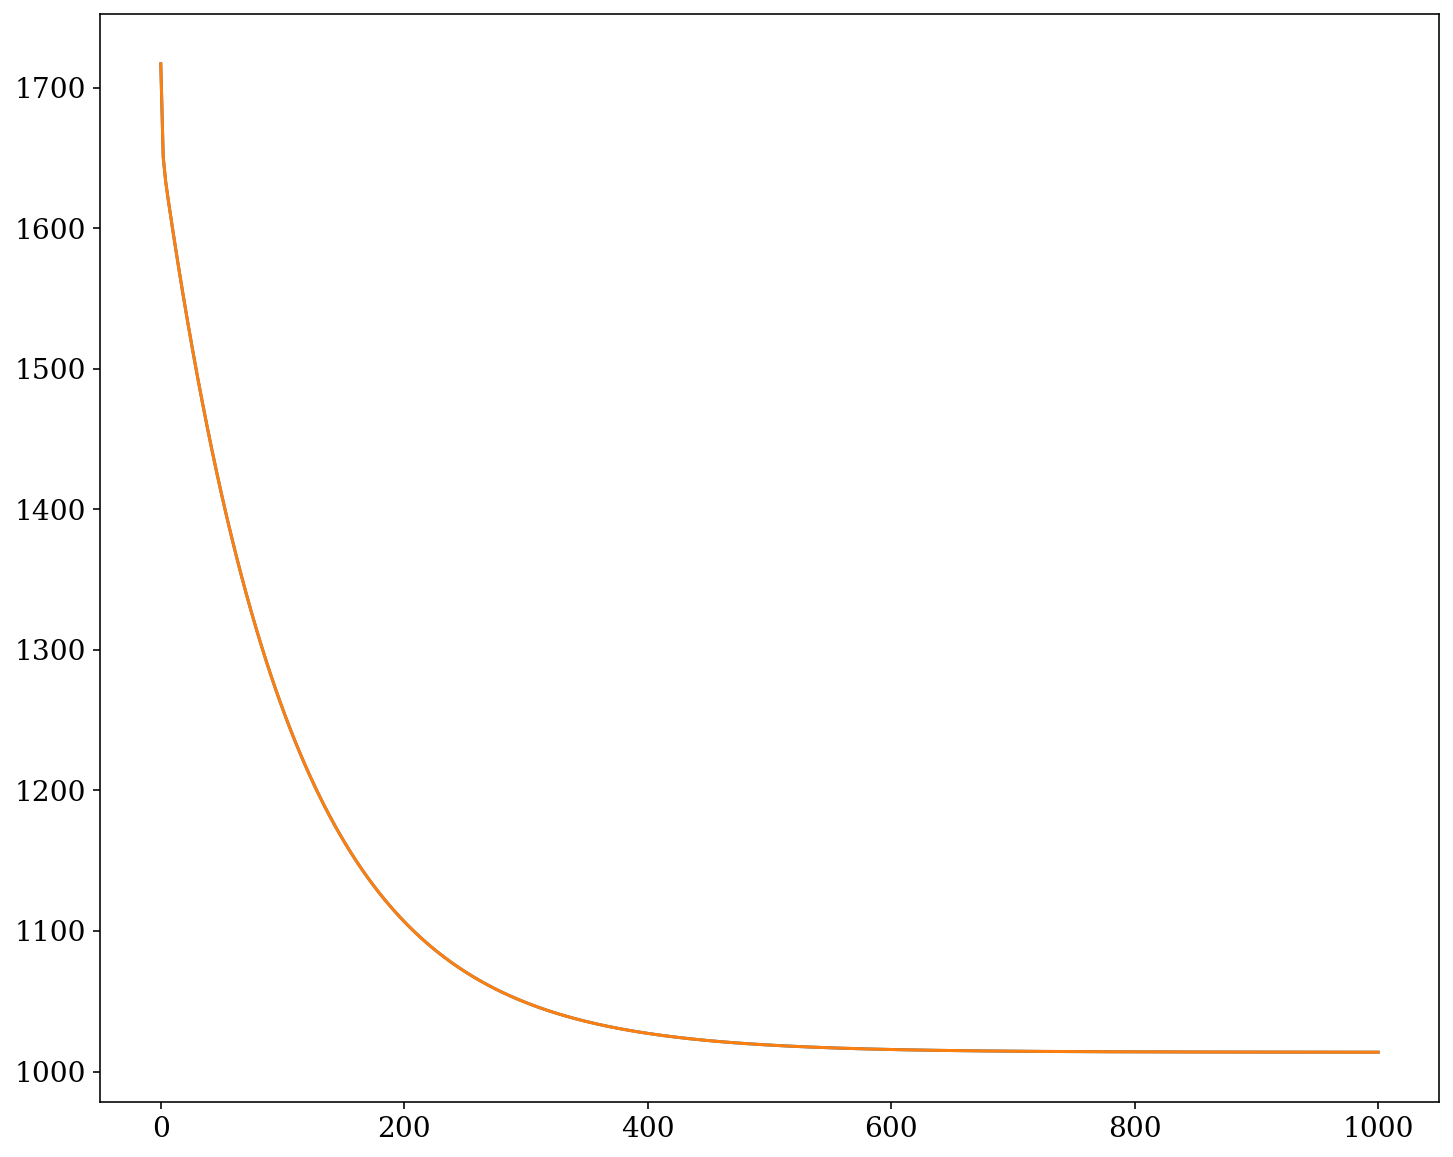

In [19]:
plt.plot(tau,a13)
plt.plot(tau,a31)

In [20]:
area = np.abs(np.trapz(a13)-np.trapz(a31))
print(area)

9.375685294799041003e-08


Parameter set 1:

In [7]:
# k23

# eq params
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

# autocorr settings
signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

# arrays for tracking aff, area, and eigs
N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
eigvals_all_r = np.zeros((N, 4), dtype=np.float128)
eigvals_all_c = np.zeros((N, 4), dtype=np.float128)

# edge to perturb
edge_idx = 1
perturb_edge = labels_f[edge_idx] # labels_f[1] = k23

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    # Track eigenvalues (real part)
    eigvals = scipy.linalg.eigvals(lap)
    eigvals_all_r[i, :] = np.sort(eigvals.real)
    eigvals_all_c[i, :] = np.sort(eigvals.imag)
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}_allones.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:35<00:00,  5.06it/s]


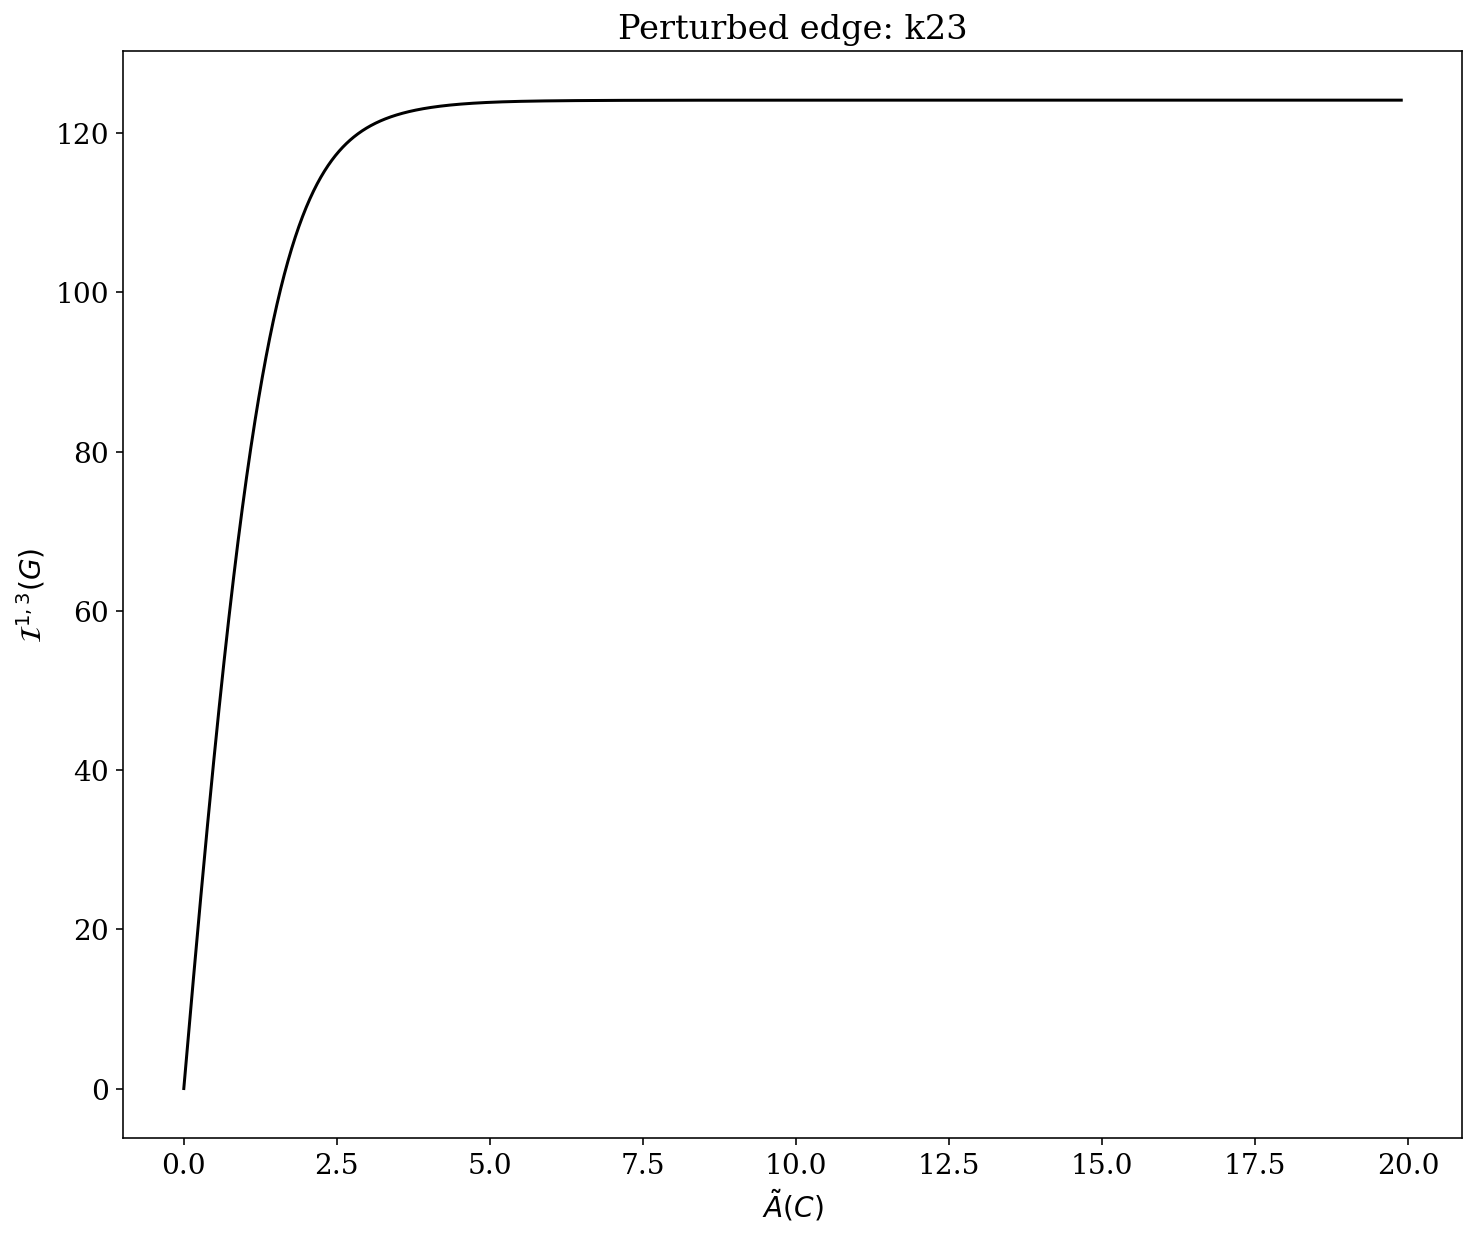

In [8]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

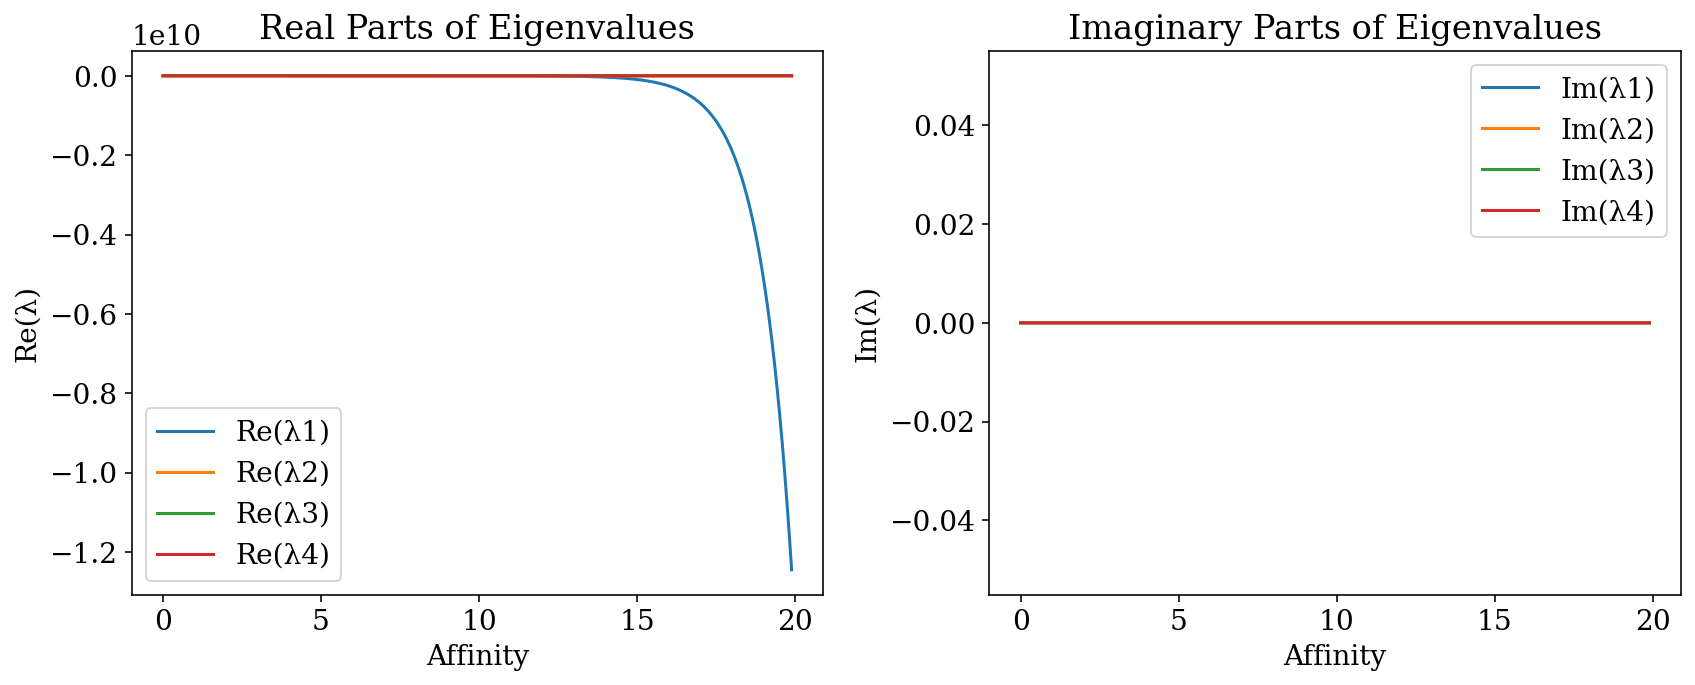

In [29]:
plt.figure(figsize=(12,5))

# Real part
plt.subplot(1,2,1)
for j in range(4):
    plt.plot(affinities, eigvals_all_r[:, j], label=f"Re(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Re(λ)")
plt.title("Real Parts of Eigenvalues")
plt.legend()

# Imaginary part
plt.subplot(1,2,2)
for j in range(4):
    plt.plot(affinities, eigvals_all_c[:, j], label=f"Im(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Im(λ)")
plt.title("Imaginary Parts of Eigenvalues")
plt.legend()

plt.tight_layout()
plt.savefig(f"eigenvalue_evolution_edge_{edge_idx}.png", dpi=300)
plt.show()


In [10]:
#k12
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
eigvals_all_r = np.zeros((N, 4), dtype=np.float128)
eigvals_all_c = np.zeros((N, 4), dtype=np.float128)
edge_idx = 0
perturb_edge = labels_f[edge_idx] # labels_f[0] = k12

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    # Track eigenvalues (real part)
    eigvals = scipy.linalg.eigvals(lap)
    eigvals_all_r[i, :] = np.sort(eigvals.real)
    eigvals_all_c[i, :] = np.sort(eigvals.imag)
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [05:16<00:00,  6.32it/s]


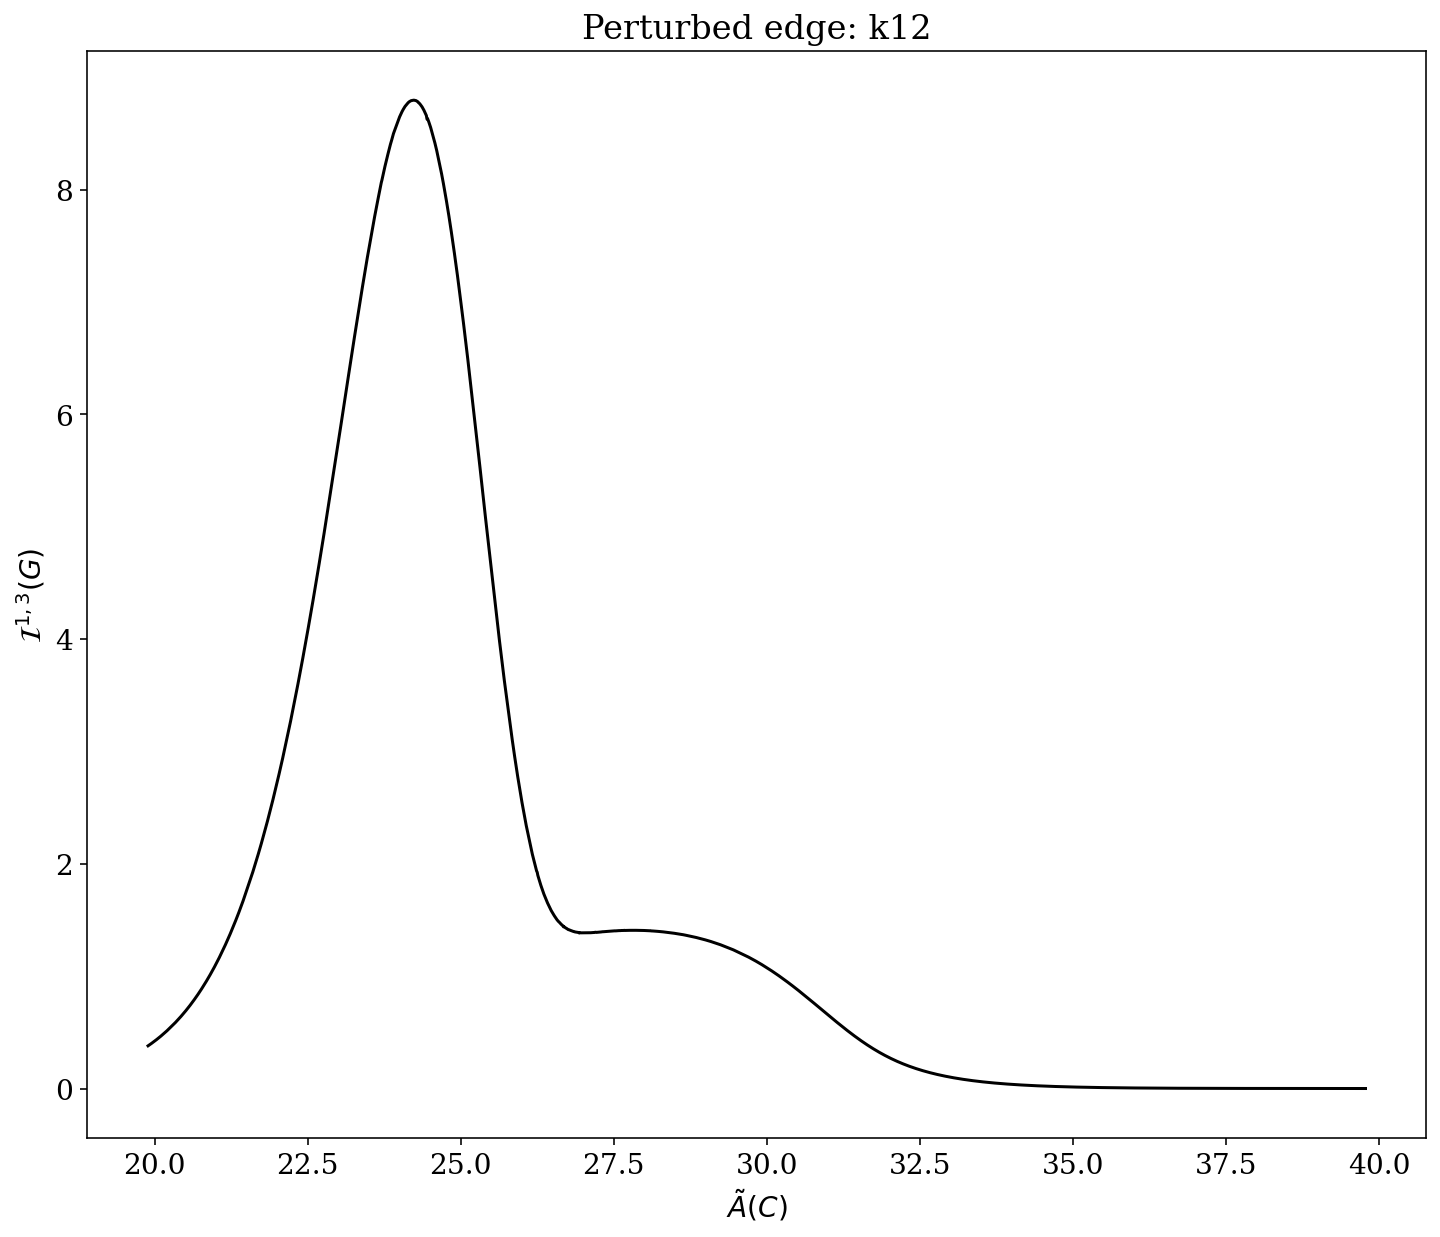

In [11]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

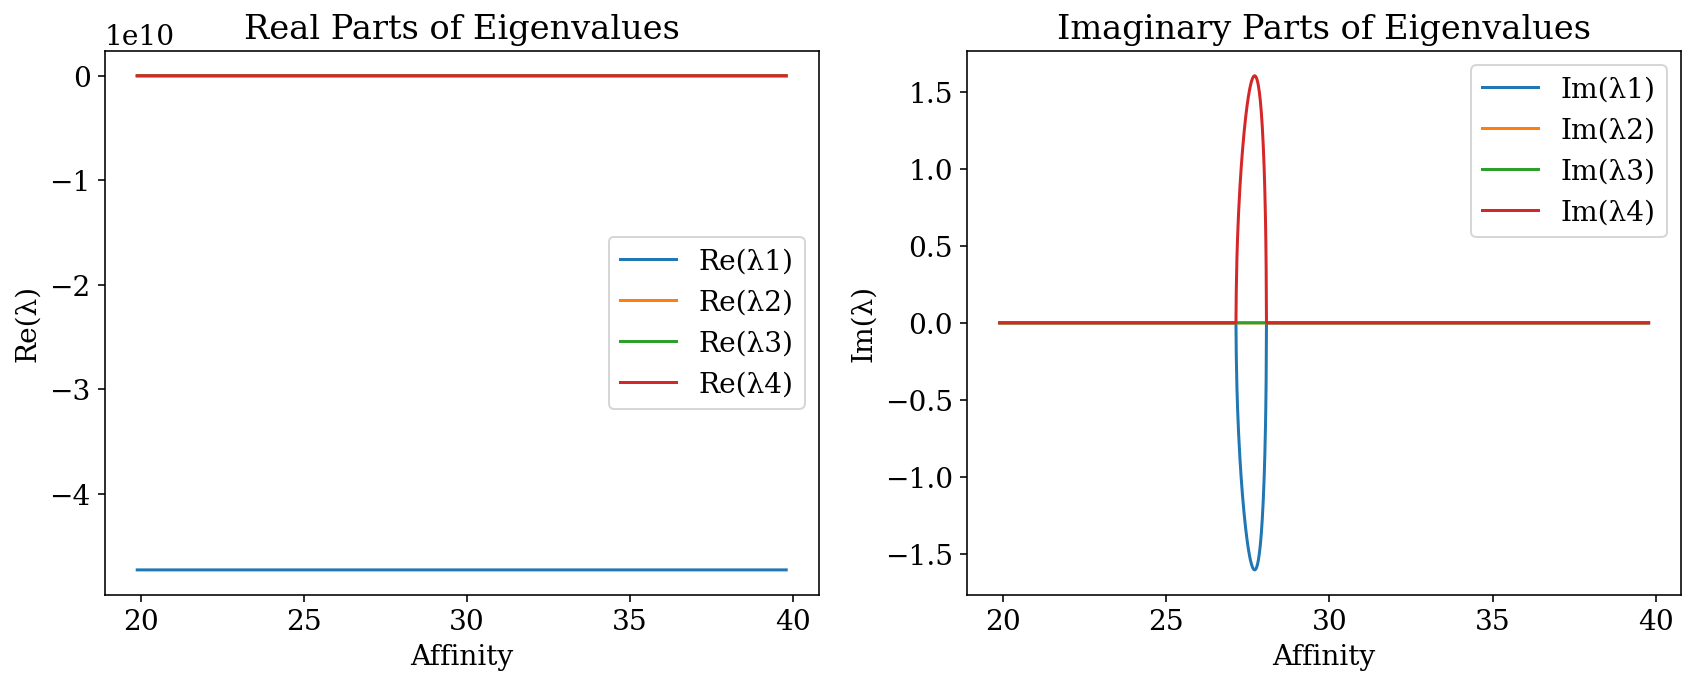

In [12]:
plt.figure(figsize=(12,5))

# Real part
plt.subplot(1,2,1)
for j in range(4):
    plt.plot(affinities, eigvals_all_r[:, j], label=f"Re(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Re(λ)")
plt.title("Real Parts of Eigenvalues")
plt.legend()

# Imaginary part
plt.subplot(1,2,2)
for j in range(4):
    plt.plot(affinities, eigvals_all_c[:, j], label=f"Im(λ{j+1})")
plt.xlabel("Affinity")
plt.ylabel("Im(λ)")
plt.title("Imaginary Parts of Eigenvalues")
plt.legend()

plt.tight_layout()
plt.savefig(f"eigenvalue_evolution_edge_{edge_idx}.png", dpi=300)
plt.show()

In [17]:
#k34
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 2
perturb_edge = labels_f[edge_idx] # labels_f[2] = k34

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [09:57<00:00,  3.35it/s]


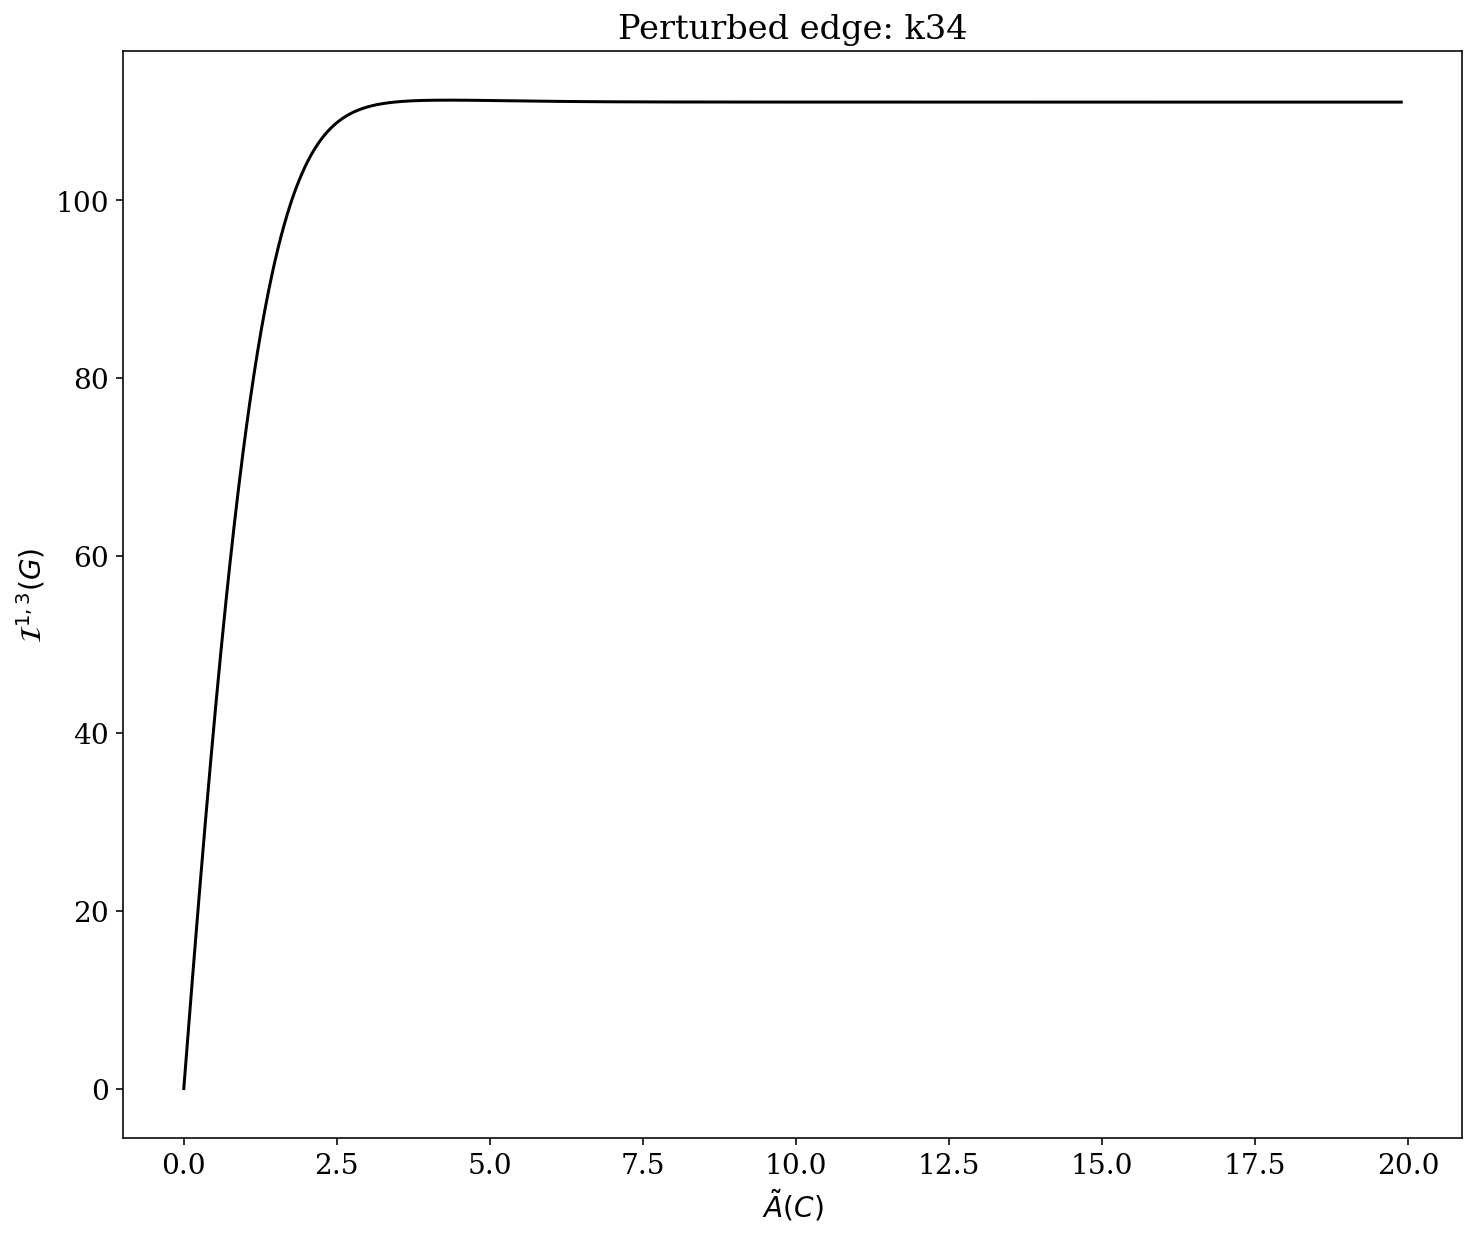

In [18]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

In [19]:
#k41
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 3
perturb_edge = labels_f[edge_idx] # labels_f[3] = k41

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [09:54<00:00,  3.36it/s]


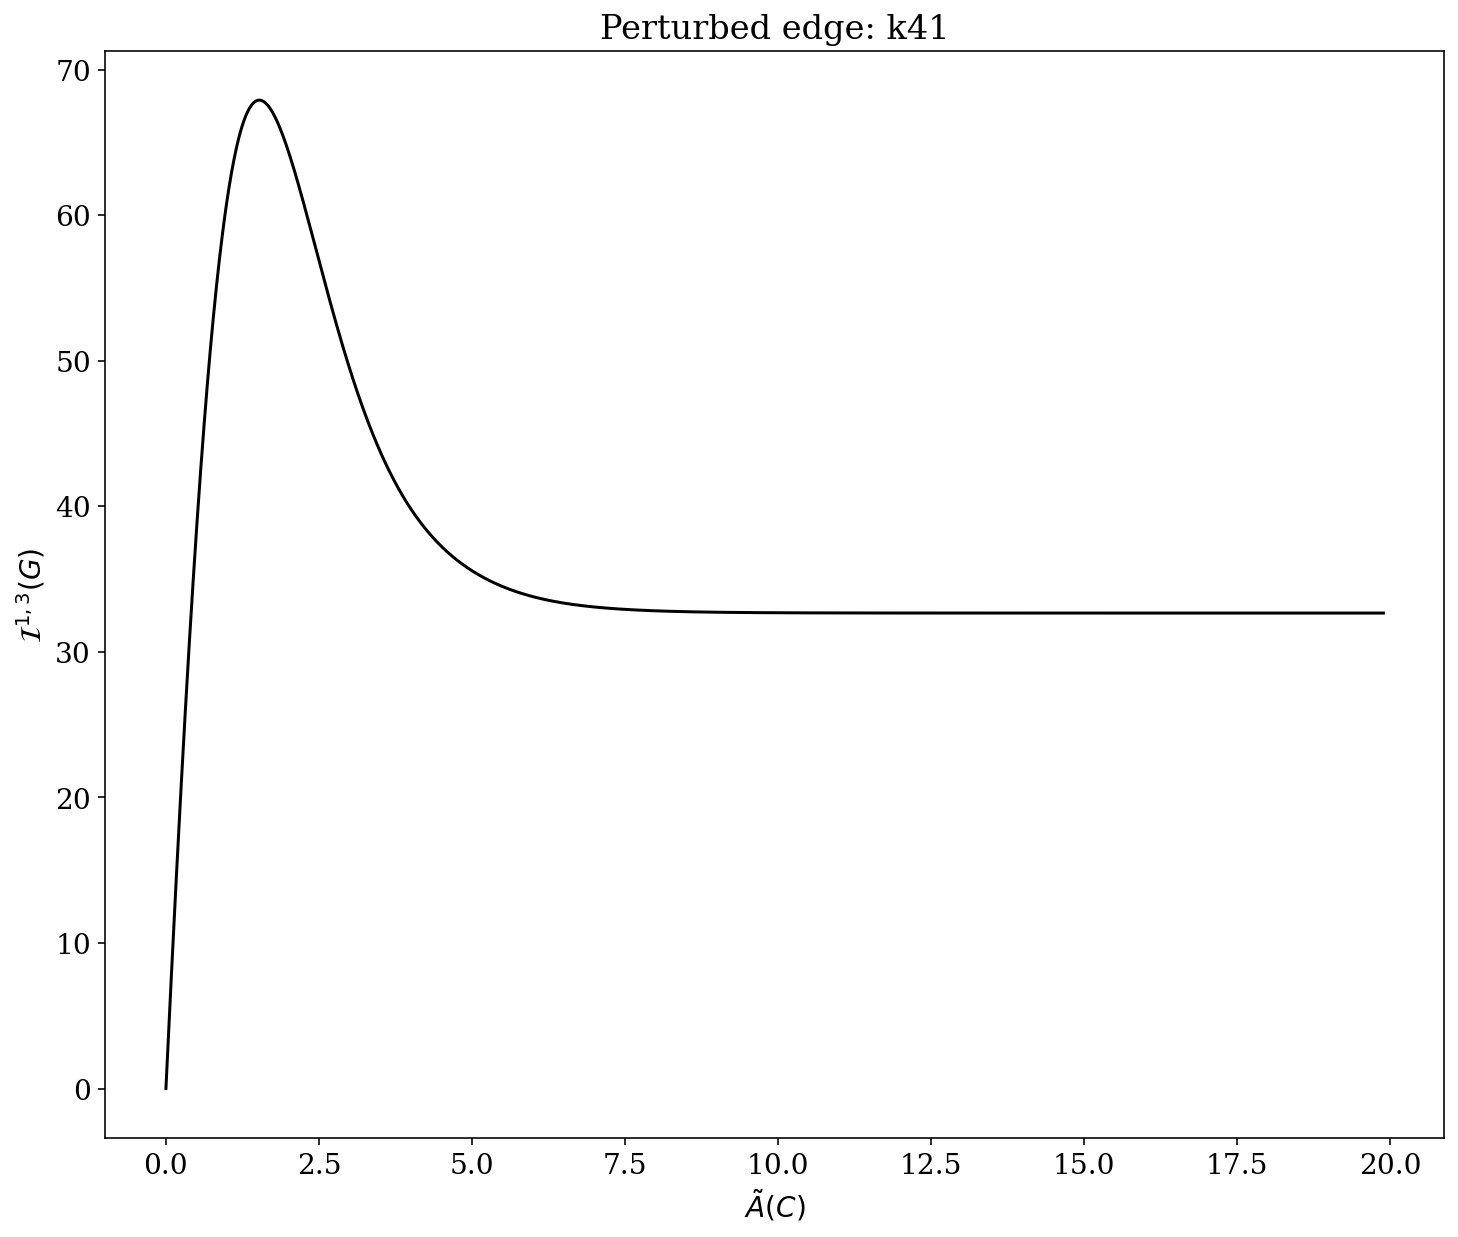

In [20]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

In [21]:
# k32
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 1
perturb_edge = labels_r[edge_idx] # labels_r[1] = k32

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:03<00:00,  5.50it/s]


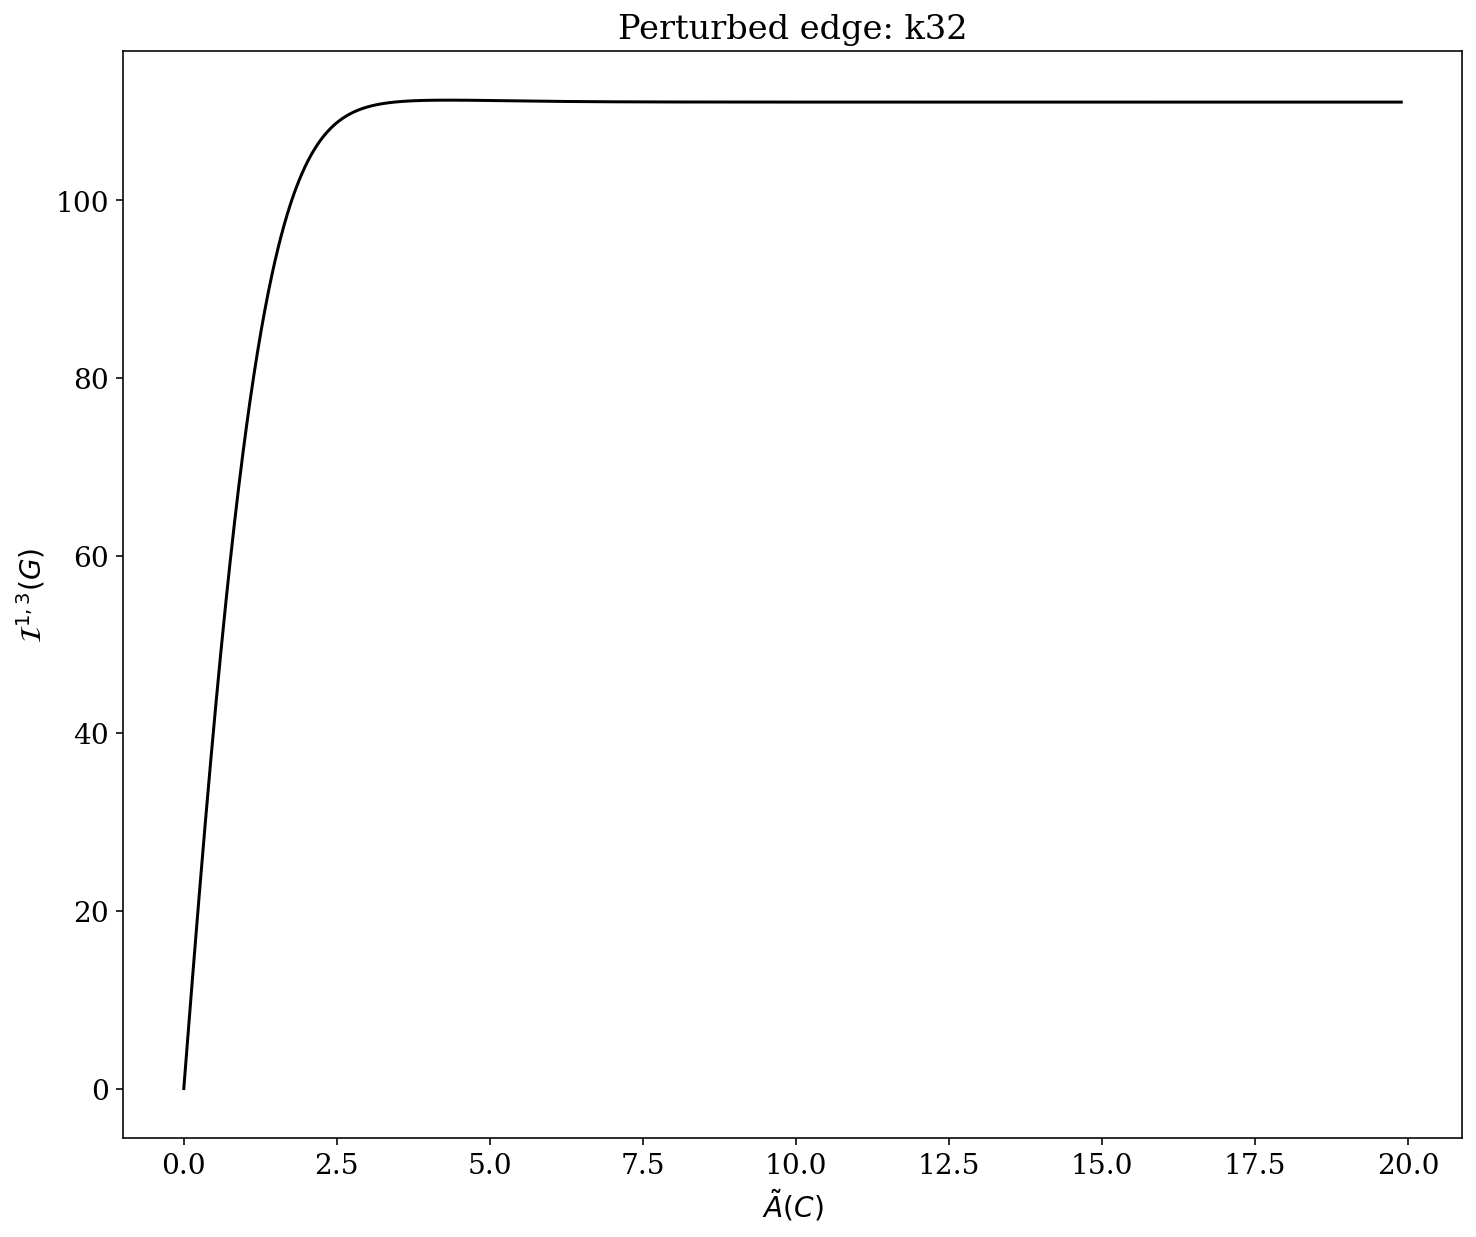

In [22]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()

In [23]:
#k21
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 0
perturb_edge = labels_r[edge_idx] # labels_r[0] = k21

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:08<00:00,  5.42it/s]


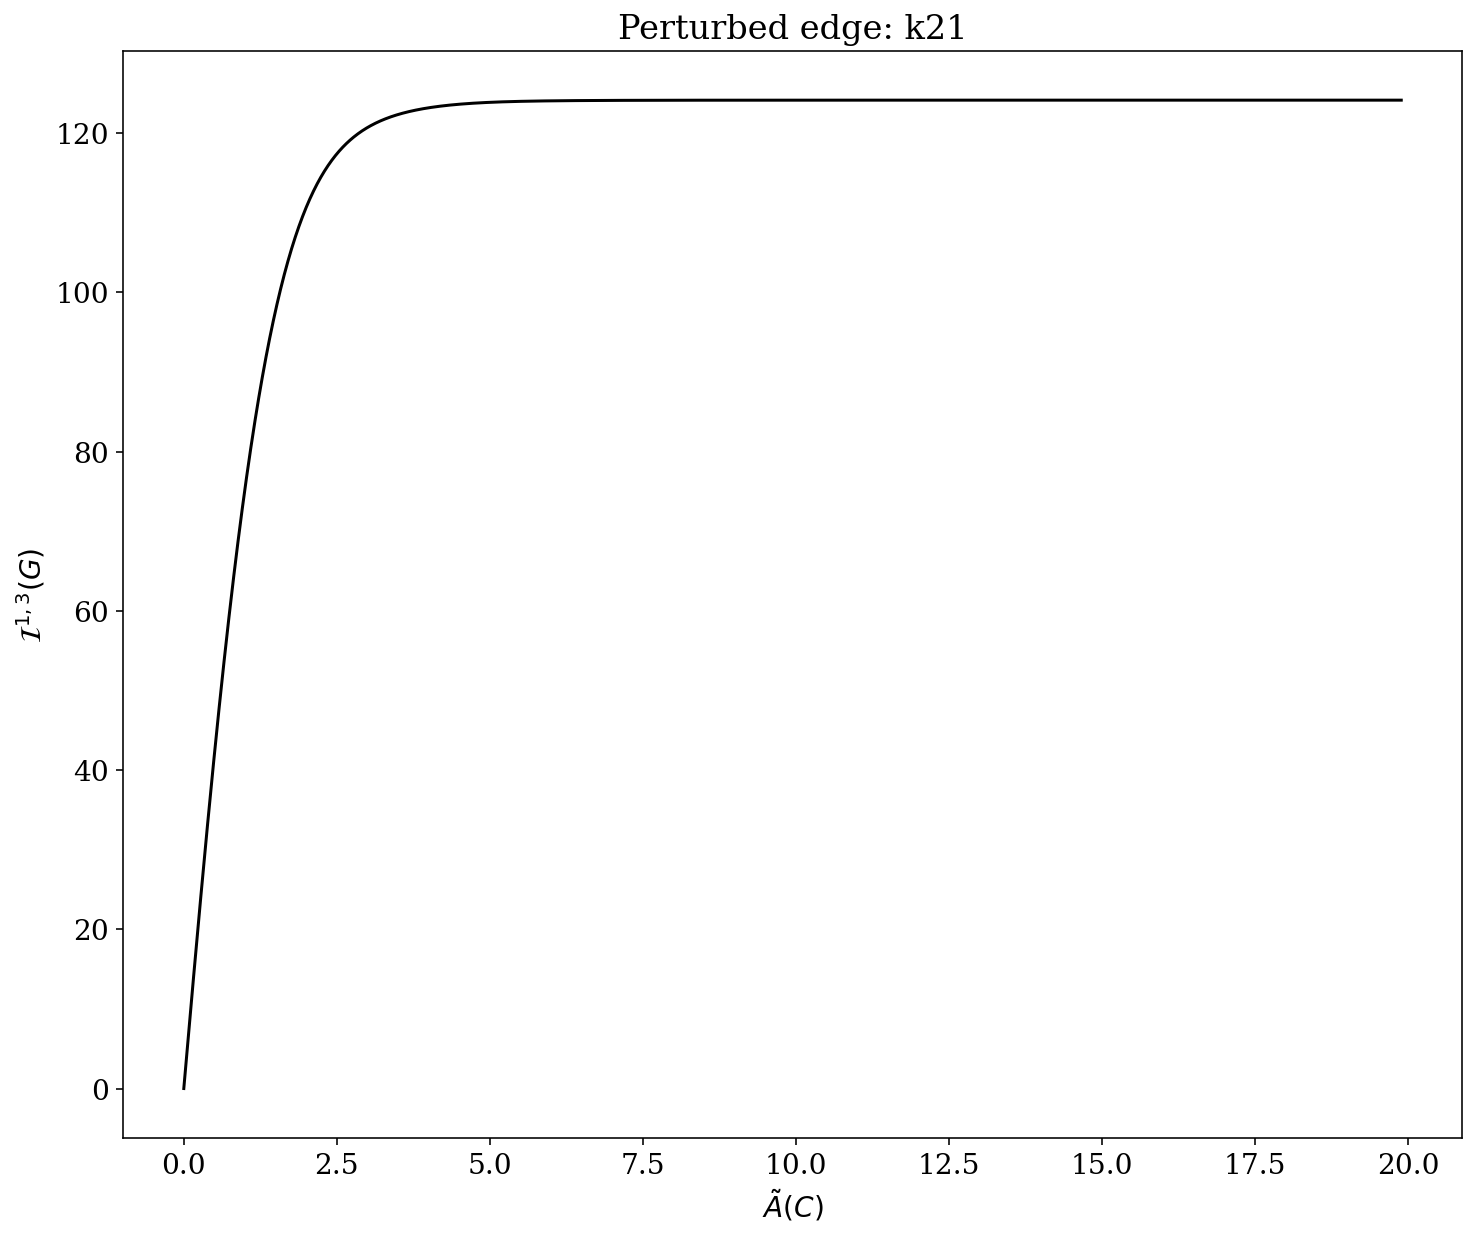

In [ ]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()

In [25]:
#k43
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 2
perturb_edge = labels_r[edge_idx] # labels_r[2] = k43

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:09<00:00,  5.41it/s]


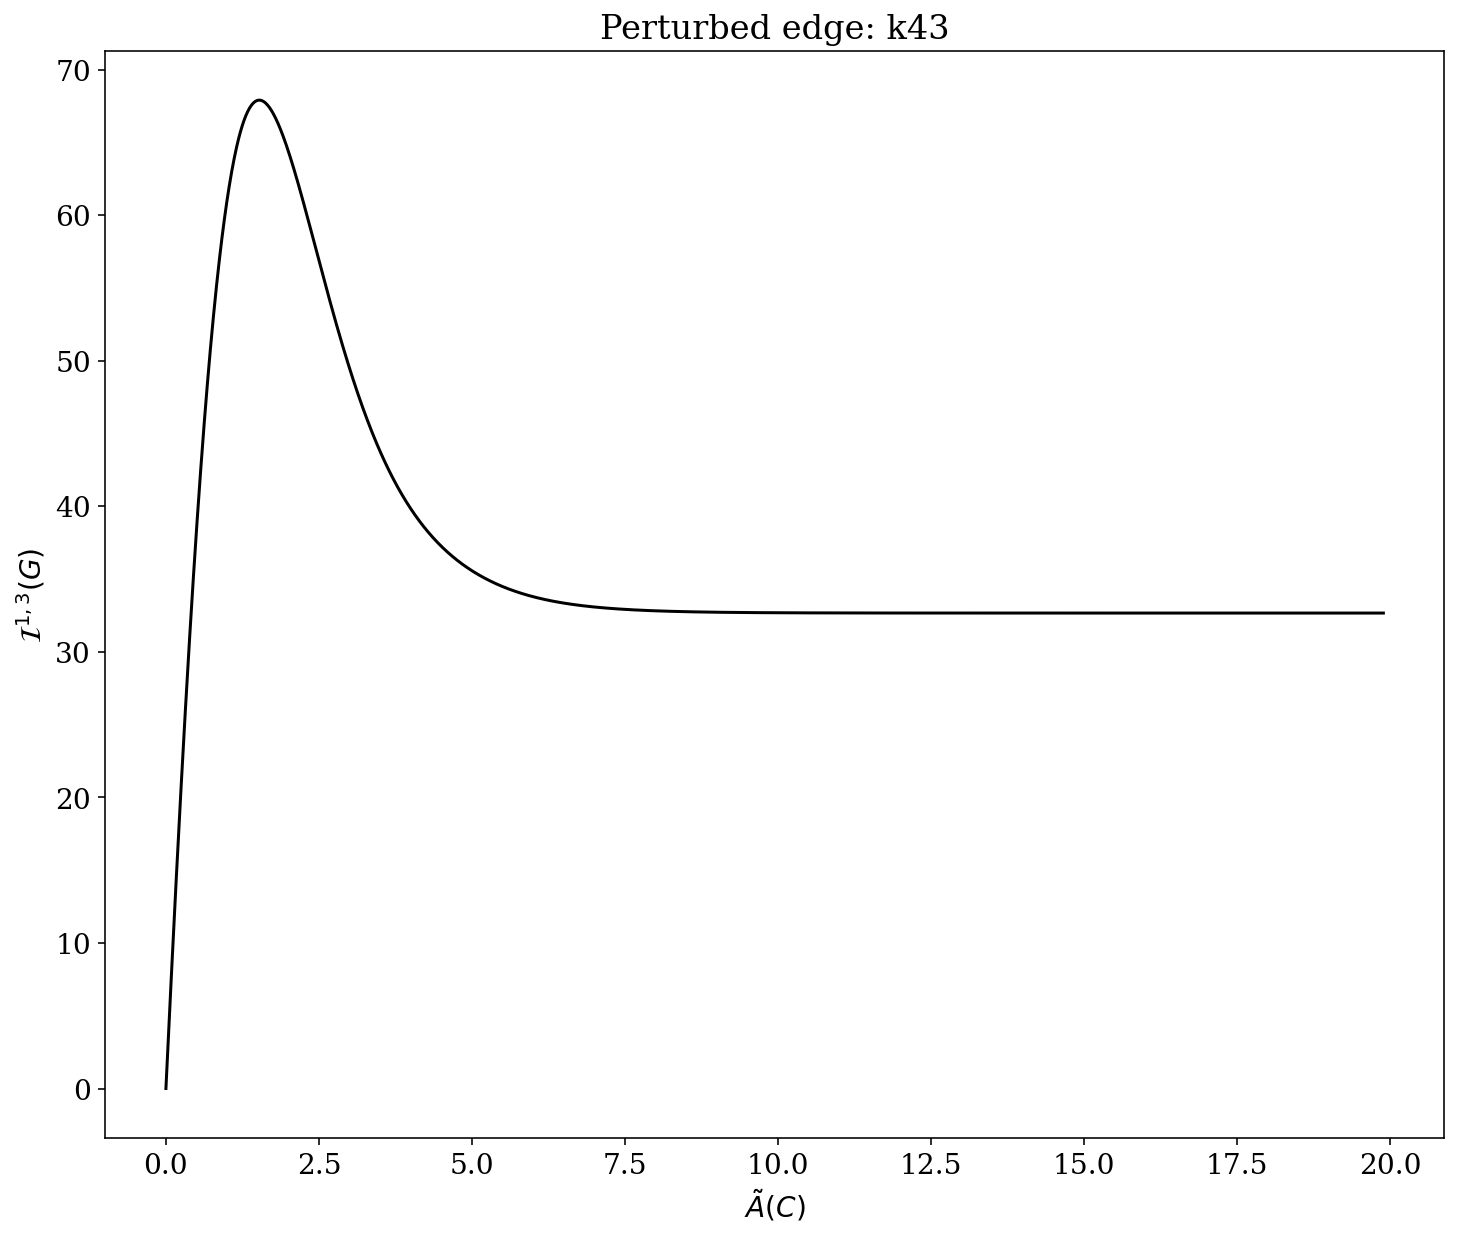

In [26]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()

In [27]:
#k14
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 3
perturb_edge = labels_r[edge_idx] # labels_r[3] = k14

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:18<00:00,  5.29it/s]


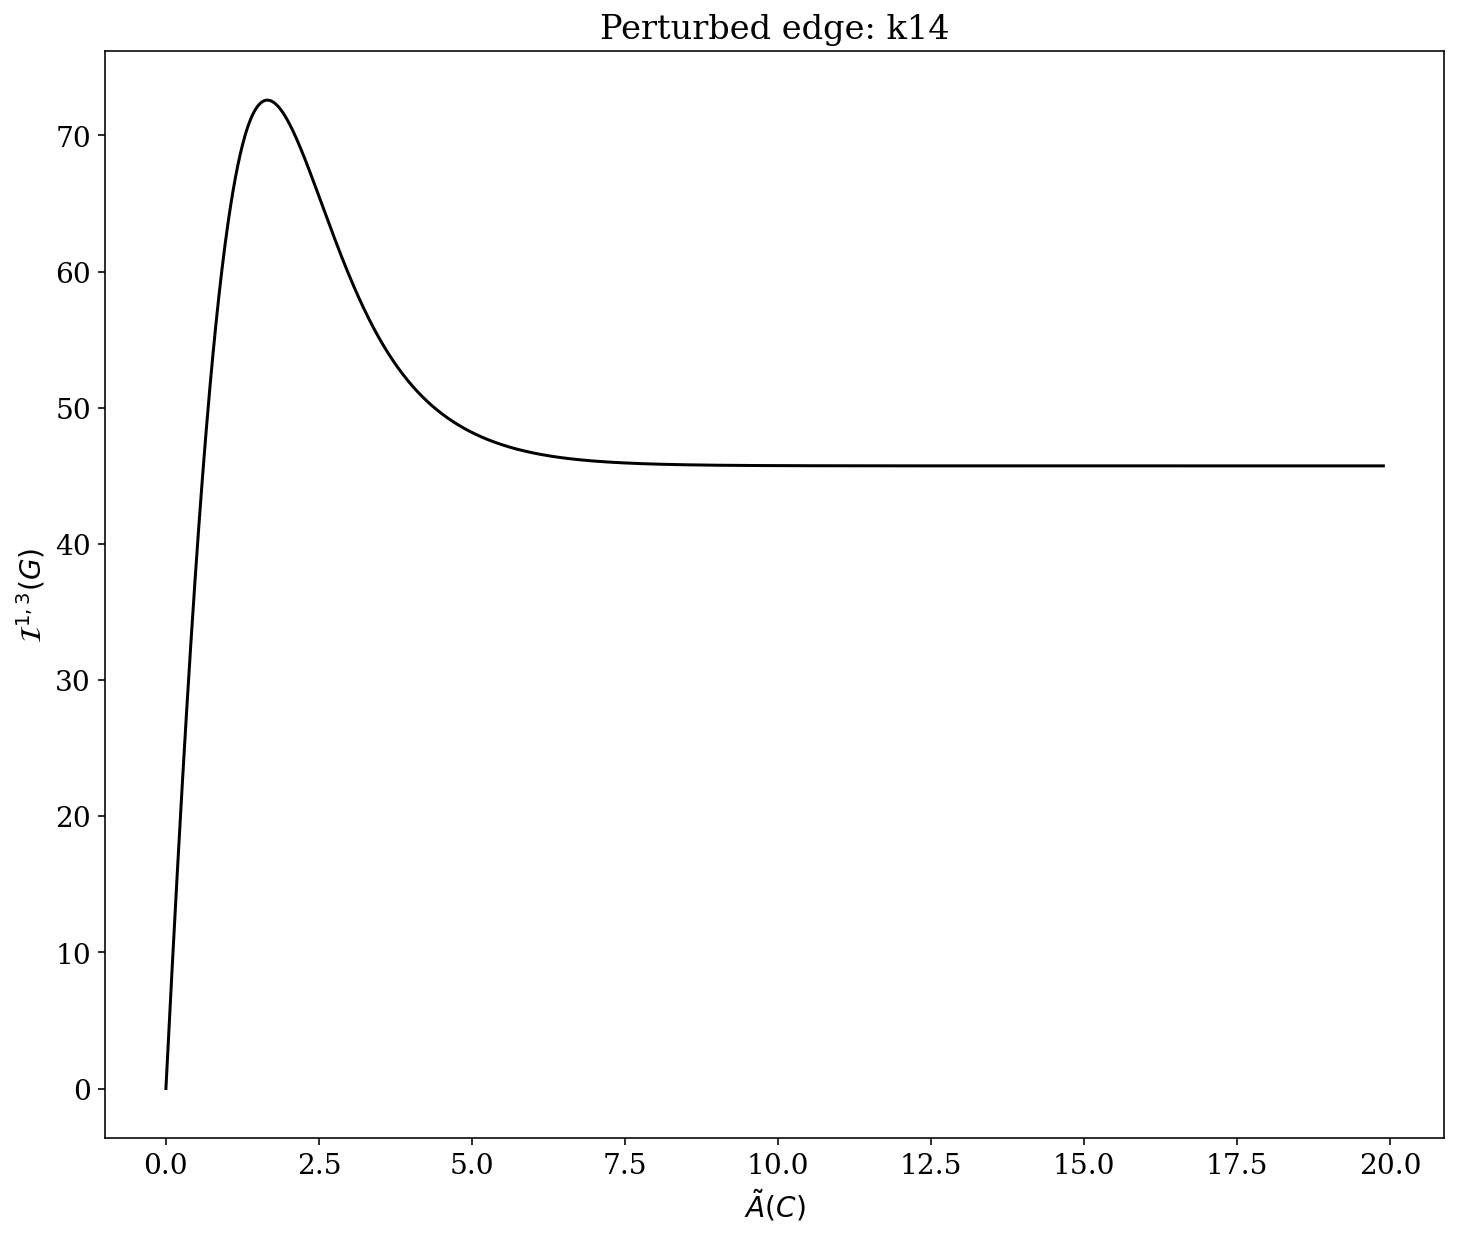

In [28]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()